In [1]:
import keras 

import pandas as pd
import numpy as np
from numpy.random import seed
seed(101)

from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

print('List folder path input')
os.listdir('../input')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


List folder path input


['basedir', 'projet-hrimech']

In [2]:
df_data = pd.read_csv('/kaggle/input/projet-hrimech/HAM10000_metadata.csv')

print('Metadata dataset')
df_data.head()

Metadata dataset


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
# Class yang terdapat pada dataset
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df_data['lesion']= df_data.dx.map(lesion_type_dict)

In [4]:
print(df_data['dx'].unique())
print(df_data.lesion.value_counts())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
lesion
Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: count, dtype: int64


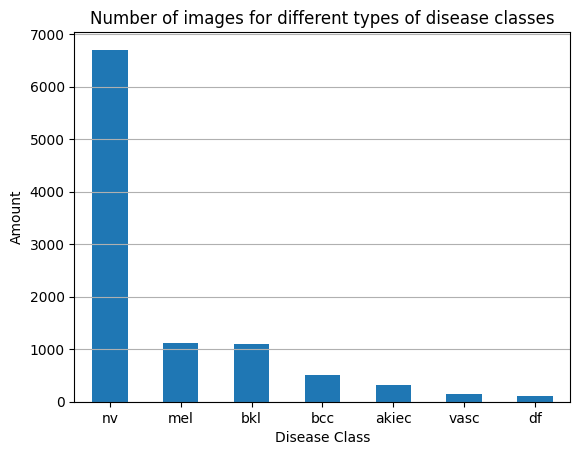

In [5]:
import matplotlib.pyplot as plt

df_data['dx'].value_counts().plot.bar(rot=0)
plt.title('Number of images for different types of disease classes')
plt.xlabel('Disease Class')
plt.ylabel('Amount')
plt.grid(axis='y')

In [6]:
# Memberi informasi berapa banyak citra yang dikaitkan dengan setiap lesion_id
df = df_data.groupby('lesion_id').count()

# Memfilter lesion_id yang hanya memiliki satu citra yang terkait dengannya
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head(20)

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion
0,HAM_0000001,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1
5,HAM_0000010,1,1,1,1,1,1,1
6,HAM_0000011,1,1,1,1,1,1,1
7,HAM_0000013,1,1,1,1,1,1,1
8,HAM_0000015,1,1,1,1,1,1,1
9,HAM_0000016,1,1,1,1,1,1,1


In [7]:
# identifikasi lesion_id yg mempunyai duplikat citra atau tidak.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# buat kolom baru yang merupakan salinan dari kolom lesi _id
df_data['duplicates'] = df_data['lesion_id']
# terapkan fungsi ke kolom baru ini
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head(30)

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis,has_duplicates
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,Benign keratosis,has_duplicates
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis,has_duplicates
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,Benign keratosis,has_duplicates
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Benign keratosis,has_duplicates
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,Benign keratosis,has_duplicates


In [8]:
df_data['duplicates'].value_counts()

duplicates
no_duplicates     5514
has_duplicates    4501
Name: count, dtype: int64

In [9]:
# filter citra yang tidak memiliki duplikat
df = df_data[df_data['duplicates'] == 'no_duplicates']

print('Images that have no duplicates are counted')
df.shape

Images that have no duplicates are counted


(5514, 9)

In [10]:
# df yang telah dipastikan tidak memiliki duplikat displit kemudian dijadikan set val (validasi)
y = df['dx']

import tensorflow
from sklearn.model_selection import train_test_split
_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

#train_size -> If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#randostate -> If int, random_state is the seed used by the random number generator
#stratif -> If not None, data is split in a stratified fashion

print('Number of images that will be used as a validation dataset')
df_val.shape

Number of images that will be used as a validation dataset


(938, 9)

In [11]:
#Membuat set train yg tidak termasuk images yg ada di set val

#Fungsi ini mengidentifikasi apakah gambar adalah bagian dari set train atau set val
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'
# buat kolom baru yang merupakan salinan dari kolom image_id
df_data['train_or_val'] = df_data['image_id']
# terapkan fungsi ke kolom baru ini
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
# filter baris set train
df_train = df_data[df_data['train_or_val'] == 'train']

print('The number of images that will be used as a train set:')
print(len(df_train))
print('The number of images that will be used as a validation set:')
print(len(df_val))

The number of images that will be used as a train set:
9077
The number of images that will be used as a validation set:
938


In [12]:
print('Jumlah citra tiap class yang akan dijadikan set train sebelum augmanted')
print(df_train['dx'].value_counts())

Jumlah citra tiap class yang akan dijadikan set train sebelum augmanted
dx
nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: count, dtype: int64


In [13]:
print('The number of images for each class that will be used as a train set before being augmented')
print(df_val['dx'].value_counts())

The number of images for each class that will be used as a train set before being augmented
dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64


In [14]:
# cek berapa banyak image di set train setiap class 
print('The amount of image data after Augmanted')
print(len(os.listdir('../input/basedir/base_dir/base_dir/train_dir/nv')))
print(len(os.listdir('../input/basedir/base_dir/base_dir/train_dir/mel')))
print(len(os.listdir('../input/basedir/base_dir/base_dir/train_dir/bkl')))
print(len(os.listdir('../input/basedir/base_dir/base_dir/train_dir/bcc')))
print(len(os.listdir('../input/basedir/base_dir/base_dir/train_dir/akiec')))
print(len(os.listdir('../input/basedir/base_dir/base_dir/train_dir/vasc')))
print(len(os.listdir('../input/basedir/base_dir/base_dir/train_dir/df')))

The amount of image data after Augmanted
5954
5920
5920
5858
5217
5290
4410


In [15]:
#Mulai membuat model

train_path = '../input/basedir/base_dir/base_dir/train_dir'
valid_path = '../input/basedir/base_dir/base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = 3857
val_steps = np.ceil(num_val_samples / val_batch_size)

In [16]:
print(train_steps)
print(val_steps)

3857
94.0


In [17]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [18]:
#Model MobileNet
mobile = keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 1s 0us/step


In [19]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [20]:
type(mobile.layers)

list

In [24]:
print('Jumlah Layer provides pre-tained MobileNet')
len(mobile.layers)

Jumlah Layer provides pre-tained MobileNet


93

In [25]:
# MEMBUAT MODEL ARCHITECTURE

# Exclude 5 layer terakhir dari model di atas.
x = mobile.layers[-6].output

x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# input = mobile.input memilih layer input 
# output = prediksi mengacu pada Dense layer yang dibuat di atas.

model = Model(inputs=mobile.input, outputs=predictions)

In [26]:
model.summary()

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_1 (InputLayer)         (None, 224, 224, 3)       0         

_________________________________________________________________

conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         

_________________________________________________________________

conv1 (Conv2D)               (None, 112, 112, 32)      864       

_________________________________________________________________

conv1_bn (BatchNormalization (None, 112, 112, 32)      128       

_________________________________________________________________

conv1_relu (ReLU)            (None, 112, 112, 32)      0         

_________________________________________________________________

conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       

_________________________________________________________________

conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [27]:
# layer yang dimiliki model
len(model.layers)

90

In [28]:
# memilih berapa banyak layer yang sebenarnya ingin di-train

# Di sini kita mem-freez weight semua lapisan kecuali 23 lapisan terakhir dalam model baru
# 23 lapisan terakhir dari model akan dilatih.

for layer in model.layers[:-23]:
    layer.trainable = False

In [29]:
#TRAIN MODEL

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [30]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [31]:
# Mendapatkan labels yang terkait dengan setiap indeks
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [32]:
# Tambahkan bobot untuk mencoba membuat model lebih sensitif terhadap melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [33]:
filepath = "model04-v5.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=5, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


Instructions for updating:

Use tf.cast instead.

Epoch 1/30

3857/3857 [==============================] - 734s 190ms/step - loss: 1.3583 - categorical_accuracy: 0.6054 - top_2_accuracy: 0.8000 - top_3_accuracy: 0.9021 - val_loss: 0.6373 - val_categorical_accuracy: 0.7868 - val_top_2_accuracy: 0.8966 - val_top_3_accuracy: 0.9552s: 1.4171 - categorical_accuracy: 0.5918 - top_2_accuracy: 0.7883 - top_3_accuracy: 0. - ETA: 2:04 - loss: 1.4169 - categorical_accuracy: 0.59 - ETA: 1:59 - loss: 1.4145 - categorical_accuracy: 0.5926 - top_2_accuracy: 0.7888 - to - ETA: 1:57 - loss: 1.4131 - categorical_accuracy: 0.5928 - top_2_accuracy: 0.7890  - ETA: 1:55 - loss: 1.4121 - categorical_accuracy: 0.5932 - top_2_accuracy: 0.7892 - top_3_accuracy: 0. - ETA: 1:55 - loss: 1.4119 - categorical_accuracy: 0.5932 - top_2_accuracy: 0.7892 - top_3_accuracy: 0. - ETA: 1:54 - loss: 1.4 - ETA: 1:46 - loss: 1.4051 - categorical_accuracy: 0.5951 - top_2_accurac - ETA: 1:43 - loss: 1.4038 - categorical_accurac

In [34]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [35]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 1.1819508966441303

val_cat_acc: 0.826226012793177

val_top_2_acc: 0.920042643923241

val_top_3_acc: 0.9552238805970149


In [36]:
# Here the best epoch will be used.

model.load_weights('model04-v5.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.5707364447228795

val_cat_acc: 0.8347547974413646

val_top_2_acc: 0.9317697228144989

val_top_3_acc: 0.9722814498933902


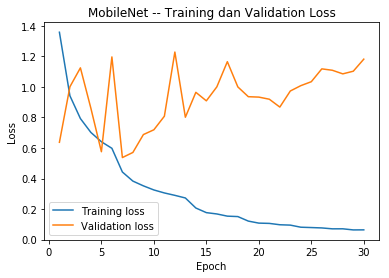

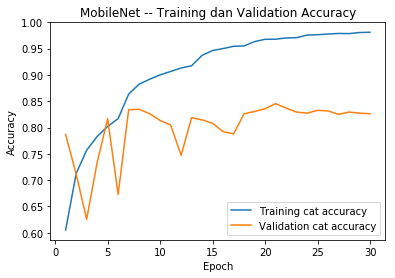

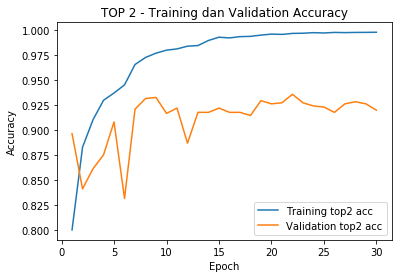

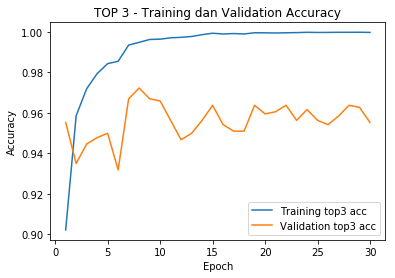

In [37]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '', label='Training loss')
plt.plot(epochs, val_loss, '', label='Validation loss')
plt.title('MobileNet -- Training dan Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, '', label='Training cat accuracy')
plt.plot(epochs, val_acc, '', label='Validation cat accuracy')
plt.title('MobileNet -- Training dan Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_top2_acc, '', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, '', label='Validation top2 acc')
plt.title('TOP 2 - Training dan Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_top3_acc, '', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, '', label='Validation top3 acc')
plt.title('TOP 3 - Training dan Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [38]:
test_labels = test_batches.classes

In [39]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [40]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [41]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

938/938 [==============================] - 14s 15ms/step


In [42]:
predictions.shape

(938, 7)

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [44]:
test_labels.shape

(938,)

In [45]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [46]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization

[[ 17   3   0   2   2   2   0]

 [  8  21   1   0   0   0   0]

 [ 27   2  10   1   8  27   0]

 [  1   0   0   2   0   3   0]

 [  9   4   0   1  15  10   0]

 [ 11   7   2   9  14 707   1]

 [  2   0   0   0   0   4   5]]


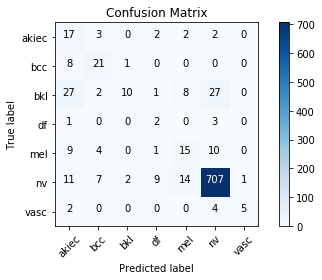

In [47]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [48]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [49]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support



       akiec       0.23      0.65      0.34        26

         bcc       0.57      0.70      0.63        30

         bkl       0.77      0.13      0.23        75

          df       0.13      0.33      0.19         6

         mel       0.38      0.38      0.38        39

          nv       0.94      0.94      0.94       751

        vasc       0.83      0.45      0.59        11



   micro avg       0.83      0.83      0.83       938

   macro avg       0.55      0.51      0.47       938

weighted avg       0.86      0.83      0.82       938




In [50]:
print('Accuracy :', val_top_3_acc)

Accuracy : 0.9722814498933902


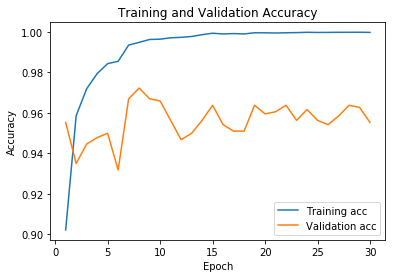

In [52]:
plt.plot(epochs, train_top3_acc, '', label='Training acc')
plt.plot(epochs, val_top3_acc, '', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()